# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:09<00:00, 6.23KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

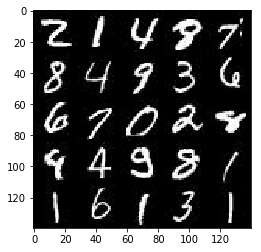

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

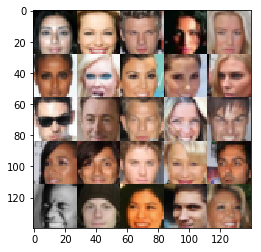

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, \
                        image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # First convolutional layer
        conv1 = tf.layers.conv2d(images, 56, 5, 2, 'SAME')
        conv1 = tf.maximum(alpha*conv1, conv1)
        
        # Second convolutional layer
        conv2 = tf.layers.conv2d(conv1, 112, 5, 2, 'SAME')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha*conv2, conv2)
        
        # Third convolutional layer
        conv3 = tf.layers.conv2d(conv2, 224, 5, 2, 'SAME')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha*conv3, conv3)
        
        # Output fully connected layer
        flat   = tf.reshape(conv3, (-1, 4*4*224))
        logits = tf.layers.dense(flat, 1)
        
        ### REVIEWER TIP ####
        # Apply dropout so that discriminator 
        # is less prone to learning the data distribution
        logits = tf.layers.dropout(logits, rate=0.5)
        
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=not(is_train)):
        
        # Input fully connected layer
        fully = tf.layers.dense(z, 7*7*112)
        fully = tf.reshape(fully, (-1, 7, 7, 112))
        fully = tf.layers.batch_normalization(fully, training=is_train)
        fully = tf.maximum(alpha*fully, fully)
        
        # First convolutional layer
        conv1 = tf.layers.conv2d_transpose(fully, 56, 5, 2, 'SAME')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha*conv1, conv1)
        
        # Output convolutional layer
        conv2 = tf.layers.conv2d_transpose(conv1, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(conv2)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
import numpy as np

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Generator model
    g_model = generator(input_z, out_channel_dim)
    
    # Discriminator models
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, True)
    
    # Discriminator losses
    #### REVIEWER TIP ####
    # Use 'One Sided Label Smoothing' on labels
    d_loss_real = tf.reduce_mean( \
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, \
        labels=tf.ones_like(d_logits_real)*np.random.uniform(0.7, 1.2)))
    d_loss_fake=tf.reduce_mean( \
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, \
        labels=tf.zeros_like(d_logits_fake)*np.random.uniform(0.0, 0.3)))
    d_loss = d_loss_real + d_loss_fake
    
    # Generator loss
    g_loss = tf.reduce_mean( \
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    # Get discriminator and generator variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Run optimizer
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    steps = 0
    print_every = 10
    show_every = 100

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model

                steps += 1
                
                #### REVIEWER SUGGESTION ####
                # Normalize input to be between -1 and 1 to match generator's images
                batch_images = batch_images*2
                
                # Get input noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
            
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval(feed_dict={input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2781... Generator Loss: 1.8310
Epoch 1/2... Discriminator Loss: 1.0403... Generator Loss: 0.6094
Epoch 1/2... Discriminator Loss: 0.6934... Generator Loss: 1.0250
Epoch 1/2... Discriminator Loss: 0.3615... Generator Loss: 4.9348
Epoch 1/2... Discriminator Loss: 0.6090... Generator Loss: 0.9392
Epoch 1/2... Discriminator Loss: 0.4355... Generator Loss: 4.1330
Epoch 1/2... Discriminator Loss: 0.4755... Generator Loss: 1.3848
Epoch 1/2... Discriminator Loss: 1.0096... Generator Loss: 0.5603
Epoch 1/2... Discriminator Loss: 0.4060... Generator Loss: 1.6699
Epoch 1/2... Discriminator Loss: 1.6542... Generator Loss: 4.5162


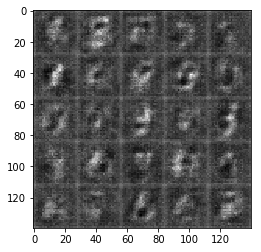

Epoch 1/2... Discriminator Loss: 0.3593... Generator Loss: 2.1287
Epoch 1/2... Discriminator Loss: 0.4328... Generator Loss: 2.4319
Epoch 1/2... Discriminator Loss: 0.7007... Generator Loss: 3.5029
Epoch 1/2... Discriminator Loss: 0.3486... Generator Loss: 2.1070
Epoch 1/2... Discriminator Loss: 1.4104... Generator Loss: 4.5887
Epoch 1/2... Discriminator Loss: 0.4977... Generator Loss: 1.1476
Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 4.6401
Epoch 1/2... Discriminator Loss: 0.3637... Generator Loss: 2.3402
Epoch 1/2... Discriminator Loss: 1.3434... Generator Loss: 4.0768
Epoch 1/2... Discriminator Loss: 0.4626... Generator Loss: 1.3218


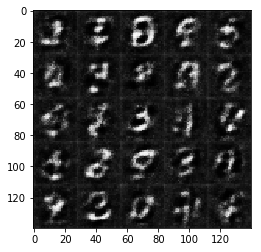

Epoch 1/2... Discriminator Loss: 2.9162... Generator Loss: 6.2162
Epoch 1/2... Discriminator Loss: 0.3240... Generator Loss: 1.8843
Epoch 1/2... Discriminator Loss: 0.6242... Generator Loss: 1.0163
Epoch 1/2... Discriminator Loss: 1.5814... Generator Loss: 0.2841
Epoch 1/2... Discriminator Loss: 0.6126... Generator Loss: 0.9683
Epoch 1/2... Discriminator Loss: 1.1649... Generator Loss: 0.4204
Epoch 1/2... Discriminator Loss: 0.9328... Generator Loss: 0.6137
Epoch 1/2... Discriminator Loss: 0.9074... Generator Loss: 0.5988
Epoch 1/2... Discriminator Loss: 0.6283... Generator Loss: 0.9685
Epoch 1/2... Discriminator Loss: 0.8013... Generator Loss: 0.7339


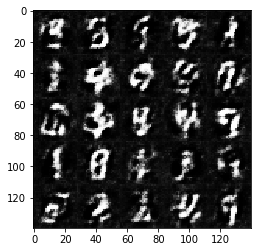

Epoch 1/2... Discriminator Loss: 0.5719... Generator Loss: 1.0720
Epoch 1/2... Discriminator Loss: 1.9353... Generator Loss: 0.1875
Epoch 1/2... Discriminator Loss: 0.3912... Generator Loss: 1.4748
Epoch 1/2... Discriminator Loss: 0.7956... Generator Loss: 0.6737
Epoch 1/2... Discriminator Loss: 0.3900... Generator Loss: 1.5491
Epoch 1/2... Discriminator Loss: 0.8775... Generator Loss: 4.6886
Epoch 1/2... Discriminator Loss: 0.5551... Generator Loss: 1.2067
Epoch 1/2... Discriminator Loss: 0.4850... Generator Loss: 1.4299
Epoch 1/2... Discriminator Loss: 0.5953... Generator Loss: 0.9909
Epoch 1/2... Discriminator Loss: 0.4585... Generator Loss: 1.3732


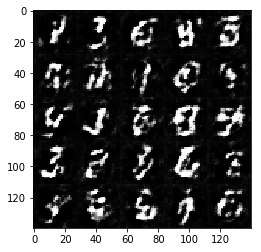

Epoch 1/2... Discriminator Loss: 0.5612... Generator Loss: 0.9891
Epoch 1/2... Discriminator Loss: 0.3148... Generator Loss: 1.8480
Epoch 1/2... Discriminator Loss: 0.5946... Generator Loss: 3.2801
Epoch 1/2... Discriminator Loss: 0.5170... Generator Loss: 1.1750
Epoch 1/2... Discriminator Loss: 0.2821... Generator Loss: 2.0981
Epoch 1/2... Discriminator Loss: 0.5284... Generator Loss: 1.0471
Epoch 1/2... Discriminator Loss: 0.2480... Generator Loss: 1.9179
Epoch 1/2... Discriminator Loss: 0.6907... Generator Loss: 0.8641
Epoch 1/2... Discriminator Loss: 0.6181... Generator Loss: 1.0240
Epoch 1/2... Discriminator Loss: 0.3607... Generator Loss: 1.5134


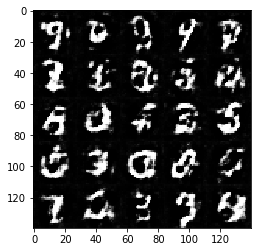

Epoch 1/2... Discriminator Loss: 0.3997... Generator Loss: 1.5193
Epoch 1/2... Discriminator Loss: 0.3088... Generator Loss: 1.7986
Epoch 1/2... Discriminator Loss: 0.3731... Generator Loss: 1.4897
Epoch 1/2... Discriminator Loss: 0.3091... Generator Loss: 1.9369
Epoch 1/2... Discriminator Loss: 0.3590... Generator Loss: 1.5777
Epoch 1/2... Discriminator Loss: 0.3940... Generator Loss: 1.6740
Epoch 1/2... Discriminator Loss: 0.4991... Generator Loss: 1.2261
Epoch 1/2... Discriminator Loss: 0.2737... Generator Loss: 2.1700
Epoch 1/2... Discriminator Loss: 1.0996... Generator Loss: 0.5551
Epoch 1/2... Discriminator Loss: 0.5105... Generator Loss: 1.2605


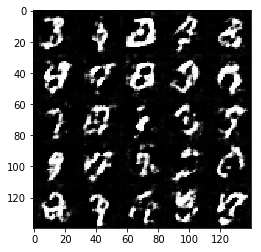

Epoch 1/2... Discriminator Loss: 0.3430... Generator Loss: 1.5005
Epoch 1/2... Discriminator Loss: 0.5520... Generator Loss: 4.2716
Epoch 1/2... Discriminator Loss: 0.4702... Generator Loss: 1.5511
Epoch 1/2... Discriminator Loss: 0.4048... Generator Loss: 1.6076
Epoch 1/2... Discriminator Loss: 0.8370... Generator Loss: 0.7645
Epoch 1/2... Discriminator Loss: 0.3782... Generator Loss: 1.4328
Epoch 1/2... Discriminator Loss: 1.0818... Generator Loss: 0.6717
Epoch 1/2... Discriminator Loss: 0.4871... Generator Loss: 1.2083
Epoch 1/2... Discriminator Loss: 0.1611... Generator Loss: 3.5713
Epoch 1/2... Discriminator Loss: 0.3522... Generator Loss: 1.6297


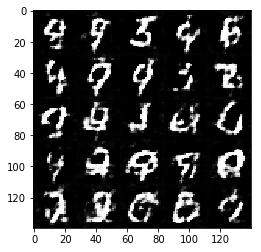

Epoch 1/2... Discriminator Loss: 0.2515... Generator Loss: 2.0163
Epoch 1/2... Discriminator Loss: 0.4769... Generator Loss: 1.2225
Epoch 1/2... Discriminator Loss: 0.3606... Generator Loss: 1.6143
Epoch 1/2... Discriminator Loss: 0.5122... Generator Loss: 1.3153
Epoch 1/2... Discriminator Loss: 0.3246... Generator Loss: 1.8168
Epoch 1/2... Discriminator Loss: 0.3806... Generator Loss: 1.5113
Epoch 1/2... Discriminator Loss: 0.2671... Generator Loss: 1.8724
Epoch 1/2... Discriminator Loss: 0.2633... Generator Loss: 2.1184
Epoch 1/2... Discriminator Loss: 2.5090... Generator Loss: 7.0547
Epoch 1/2... Discriminator Loss: 0.4216... Generator Loss: 1.4631


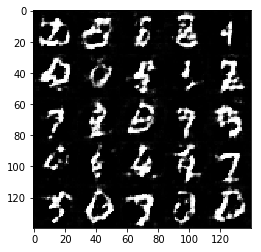

Epoch 1/2... Discriminator Loss: 0.4063... Generator Loss: 1.5130
Epoch 1/2... Discriminator Loss: 0.6339... Generator Loss: 0.9983
Epoch 1/2... Discriminator Loss: 0.5970... Generator Loss: 1.0810
Epoch 1/2... Discriminator Loss: 0.6944... Generator Loss: 1.0663
Epoch 1/2... Discriminator Loss: 0.7686... Generator Loss: 0.8148
Epoch 1/2... Discriminator Loss: 0.3001... Generator Loss: 1.6612
Epoch 1/2... Discriminator Loss: 0.3644... Generator Loss: 3.6996
Epoch 1/2... Discriminator Loss: 0.5658... Generator Loss: 1.0862
Epoch 1/2... Discriminator Loss: 1.0224... Generator Loss: 0.6425
Epoch 1/2... Discriminator Loss: 0.5184... Generator Loss: 2.9259


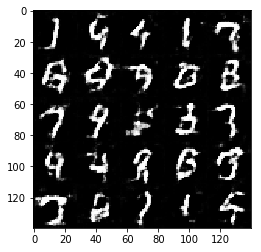

Epoch 1/2... Discriminator Loss: 0.6699... Generator Loss: 0.9136
Epoch 1/2... Discriminator Loss: 2.8391... Generator Loss: 0.1420
Epoch 1/2... Discriminator Loss: 0.4566... Generator Loss: 1.4190
Epoch 1/2... Discriminator Loss: 0.3561... Generator Loss: 2.3646
Epoch 1/2... Discriminator Loss: 0.3688... Generator Loss: 1.7145
Epoch 1/2... Discriminator Loss: 1.0181... Generator Loss: 0.5552
Epoch 1/2... Discriminator Loss: 0.6395... Generator Loss: 0.9573
Epoch 1/2... Discriminator Loss: 0.3524... Generator Loss: 2.3954
Epoch 1/2... Discriminator Loss: 0.9708... Generator Loss: 0.7245
Epoch 1/2... Discriminator Loss: 0.3150... Generator Loss: 2.0441


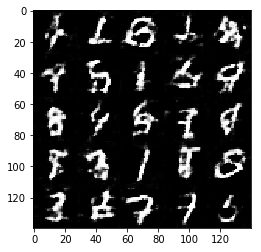

Epoch 1/2... Discriminator Loss: 0.7435... Generator Loss: 3.8263
Epoch 1/2... Discriminator Loss: 0.4554... Generator Loss: 1.4582
Epoch 1/2... Discriminator Loss: 1.4891... Generator Loss: 0.3576
Epoch 1/2... Discriminator Loss: 0.7472... Generator Loss: 0.8874
Epoch 1/2... Discriminator Loss: 0.7406... Generator Loss: 0.8870
Epoch 1/2... Discriminator Loss: 1.5716... Generator Loss: 0.3329
Epoch 1/2... Discriminator Loss: 0.6154... Generator Loss: 1.0531
Epoch 1/2... Discriminator Loss: 0.6802... Generator Loss: 1.0545
Epoch 1/2... Discriminator Loss: 0.4624... Generator Loss: 1.3987
Epoch 1/2... Discriminator Loss: 0.4346... Generator Loss: 1.8532


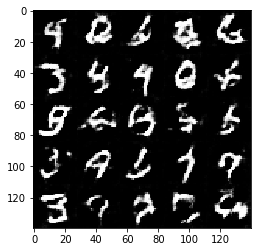

Epoch 1/2... Discriminator Loss: 0.3492... Generator Loss: 1.7459
Epoch 1/2... Discriminator Loss: 0.4675... Generator Loss: 1.3852
Epoch 1/2... Discriminator Loss: 1.3116... Generator Loss: 0.4136
Epoch 1/2... Discriminator Loss: 0.4972... Generator Loss: 1.3473
Epoch 1/2... Discriminator Loss: 0.5980... Generator Loss: 1.0444
Epoch 1/2... Discriminator Loss: 0.6003... Generator Loss: 1.1060
Epoch 1/2... Discriminator Loss: 0.3115... Generator Loss: 1.9613
Epoch 1/2... Discriminator Loss: 0.3770... Generator Loss: 1.5413
Epoch 1/2... Discriminator Loss: 0.5747... Generator Loss: 1.0898
Epoch 1/2... Discriminator Loss: 0.6534... Generator Loss: 0.9526


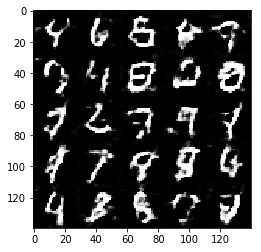

Epoch 1/2... Discriminator Loss: 1.6349... Generator Loss: 0.2806
Epoch 1/2... Discriminator Loss: 0.2943... Generator Loss: 2.3337
Epoch 1/2... Discriminator Loss: 1.6524... Generator Loss: 0.2685
Epoch 1/2... Discriminator Loss: 1.1587... Generator Loss: 0.4661
Epoch 1/2... Discriminator Loss: 0.4928... Generator Loss: 2.1812
Epoch 1/2... Discriminator Loss: 0.3097... Generator Loss: 2.7951
Epoch 1/2... Discriminator Loss: 0.6687... Generator Loss: 0.9263
Epoch 1/2... Discriminator Loss: 0.7972... Generator Loss: 0.7728
Epoch 1/2... Discriminator Loss: 0.7838... Generator Loss: 0.8399
Epoch 1/2... Discriminator Loss: 0.5223... Generator Loss: 2.0685


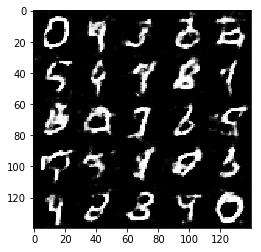

Epoch 1/2... Discriminator Loss: 0.3578... Generator Loss: 1.9308
Epoch 1/2... Discriminator Loss: 0.4371... Generator Loss: 1.4901
Epoch 1/2... Discriminator Loss: 0.2819... Generator Loss: 1.7935
Epoch 1/2... Discriminator Loss: 0.3525... Generator Loss: 1.5046
Epoch 1/2... Discriminator Loss: 0.5774... Generator Loss: 1.0416
Epoch 1/2... Discriminator Loss: 1.0376... Generator Loss: 0.5580
Epoch 1/2... Discriminator Loss: 0.6468... Generator Loss: 0.9703
Epoch 1/2... Discriminator Loss: 3.3773... Generator Loss: 6.3753
Epoch 1/2... Discriminator Loss: 0.8816... Generator Loss: 0.7004
Epoch 1/2... Discriminator Loss: 0.5007... Generator Loss: 1.1482


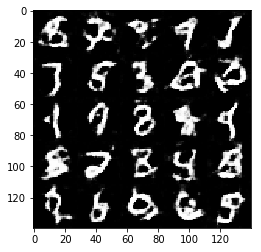

Epoch 1/2... Discriminator Loss: 0.3884... Generator Loss: 1.7150
Epoch 1/2... Discriminator Loss: 0.3954... Generator Loss: 1.6447
Epoch 1/2... Discriminator Loss: 0.3397... Generator Loss: 1.6697
Epoch 1/2... Discriminator Loss: 0.9009... Generator Loss: 0.6496
Epoch 1/2... Discriminator Loss: 0.5781... Generator Loss: 1.1237
Epoch 1/2... Discriminator Loss: 0.6401... Generator Loss: 0.9467
Epoch 1/2... Discriminator Loss: 0.3960... Generator Loss: 1.3109
Epoch 1/2... Discriminator Loss: 0.5977... Generator Loss: 0.9633
Epoch 1/2... Discriminator Loss: 0.6067... Generator Loss: 0.9686
Epoch 1/2... Discriminator Loss: 2.1747... Generator Loss: 0.1962


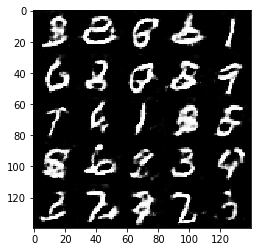

Epoch 1/2... Discriminator Loss: 0.7528... Generator Loss: 0.8703
Epoch 1/2... Discriminator Loss: 0.4475... Generator Loss: 1.3483
Epoch 1/2... Discriminator Loss: 0.4119... Generator Loss: 1.4916
Epoch 1/2... Discriminator Loss: 0.4040... Generator Loss: 1.3514
Epoch 1/2... Discriminator Loss: 0.4063... Generator Loss: 1.4391
Epoch 1/2... Discriminator Loss: 0.5231... Generator Loss: 1.1891
Epoch 1/2... Discriminator Loss: 1.0817... Generator Loss: 0.6679
Epoch 1/2... Discriminator Loss: 0.3588... Generator Loss: 1.6734
Epoch 1/2... Discriminator Loss: 0.3146... Generator Loss: 3.5359
Epoch 1/2... Discriminator Loss: 0.3517... Generator Loss: 1.7085


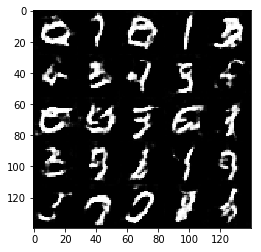

Epoch 1/2... Discriminator Loss: 0.4023... Generator Loss: 1.4224
Epoch 1/2... Discriminator Loss: 0.3069... Generator Loss: 1.6376
Epoch 1/2... Discriminator Loss: 0.4359... Generator Loss: 1.3483
Epoch 1/2... Discriminator Loss: 0.5928... Generator Loss: 0.9777
Epoch 1/2... Discriminator Loss: 0.4553... Generator Loss: 1.2206
Epoch 1/2... Discriminator Loss: 0.2525... Generator Loss: 2.5357
Epoch 1/2... Discriminator Loss: 0.5109... Generator Loss: 2.6084
Epoch 1/2... Discriminator Loss: 0.4659... Generator Loss: 2.9437
Epoch 1/2... Discriminator Loss: 0.3558... Generator Loss: 1.5256
Epoch 1/2... Discriminator Loss: 1.1865... Generator Loss: 0.4432


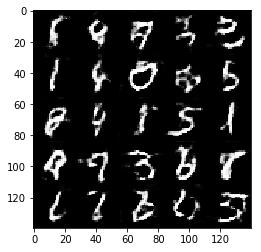

Epoch 1/2... Discriminator Loss: 0.5270... Generator Loss: 1.1681
Epoch 1/2... Discriminator Loss: 0.3783... Generator Loss: 1.4545
Epoch 1/2... Discriminator Loss: 0.4579... Generator Loss: 1.3117
Epoch 1/2... Discriminator Loss: 0.5537... Generator Loss: 1.0337
Epoch 1/2... Discriminator Loss: 0.6694... Generator Loss: 1.0099
Epoch 1/2... Discriminator Loss: 0.5491... Generator Loss: 1.2922
Epoch 1/2... Discriminator Loss: 0.5037... Generator Loss: 1.2307
Epoch 1/2... Discriminator Loss: 0.4149... Generator Loss: 1.3000
Epoch 1/2... Discriminator Loss: 0.4466... Generator Loss: 1.3106
Epoch 1/2... Discriminator Loss: 0.2943... Generator Loss: 1.7143


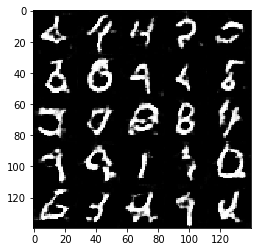

Epoch 1/2... Discriminator Loss: 0.6295... Generator Loss: 0.9593
Epoch 1/2... Discriminator Loss: 0.5552... Generator Loss: 1.0960
Epoch 1/2... Discriminator Loss: 1.0056... Generator Loss: 0.6194
Epoch 1/2... Discriminator Loss: 0.9382... Generator Loss: 0.7820
Epoch 1/2... Discriminator Loss: 0.6659... Generator Loss: 0.9707
Epoch 1/2... Discriminator Loss: 0.5343... Generator Loss: 1.1034
Epoch 1/2... Discriminator Loss: 0.3282... Generator Loss: 1.7149
Epoch 2/2... Discriminator Loss: 0.3572... Generator Loss: 1.4722
Epoch 2/2... Discriminator Loss: 0.4669... Generator Loss: 1.2149
Epoch 2/2... Discriminator Loss: 0.4247... Generator Loss: 1.3392


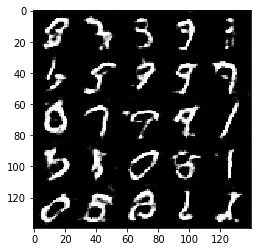

Epoch 2/2... Discriminator Loss: 0.7545... Generator Loss: 0.7526
Epoch 2/2... Discriminator Loss: 0.4173... Generator Loss: 1.6076
Epoch 2/2... Discriminator Loss: 0.3235... Generator Loss: 1.6408
Epoch 2/2... Discriminator Loss: 0.3838... Generator Loss: 1.3490
Epoch 2/2... Discriminator Loss: 0.2991... Generator Loss: 1.7077
Epoch 2/2... Discriminator Loss: 0.6566... Generator Loss: 0.9617
Epoch 2/2... Discriminator Loss: 0.5302... Generator Loss: 1.2607
Epoch 2/2... Discriminator Loss: 0.8039... Generator Loss: 0.8067
Epoch 2/2... Discriminator Loss: 0.5614... Generator Loss: 1.0810
Epoch 2/2... Discriminator Loss: 0.2772... Generator Loss: 1.8836


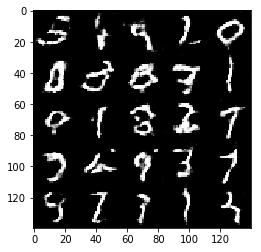

Epoch 2/2... Discriminator Loss: 0.2872... Generator Loss: 1.6602
Epoch 2/2... Discriminator Loss: 0.3516... Generator Loss: 1.4016
Epoch 2/2... Discriminator Loss: 0.2751... Generator Loss: 1.7372
Epoch 2/2... Discriminator Loss: 0.5163... Generator Loss: 1.1606
Epoch 2/2... Discriminator Loss: 0.5114... Generator Loss: 1.2166
Epoch 2/2... Discriminator Loss: 2.1724... Generator Loss: 0.1918
Epoch 2/2... Discriminator Loss: 0.3519... Generator Loss: 1.4787
Epoch 2/2... Discriminator Loss: 0.5872... Generator Loss: 1.0880
Epoch 2/2... Discriminator Loss: 0.5173... Generator Loss: 1.1332
Epoch 2/2... Discriminator Loss: 0.3813... Generator Loss: 1.4561


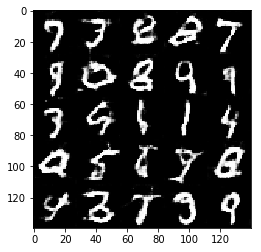

Epoch 2/2... Discriminator Loss: 0.4824... Generator Loss: 1.2793
Epoch 2/2... Discriminator Loss: 0.4794... Generator Loss: 1.2320
Epoch 2/2... Discriminator Loss: 0.5447... Generator Loss: 1.1770
Epoch 2/2... Discriminator Loss: 0.6400... Generator Loss: 3.3845
Epoch 2/2... Discriminator Loss: 0.4354... Generator Loss: 3.0581
Epoch 2/2... Discriminator Loss: 0.3483... Generator Loss: 1.5343
Epoch 2/2... Discriminator Loss: 0.7904... Generator Loss: 0.8472
Epoch 2/2... Discriminator Loss: 0.4344... Generator Loss: 1.3170
Epoch 2/2... Discriminator Loss: 0.8166... Generator Loss: 0.8009
Epoch 2/2... Discriminator Loss: 0.4663... Generator Loss: 1.3680


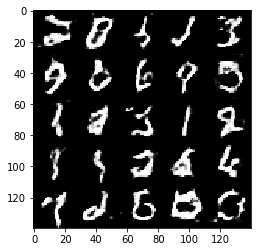

Epoch 2/2... Discriminator Loss: 0.3460... Generator Loss: 1.4777
Epoch 2/2... Discriminator Loss: 0.7323... Generator Loss: 0.8093
Epoch 2/2... Discriminator Loss: 0.4534... Generator Loss: 1.2333
Epoch 2/2... Discriminator Loss: 1.0381... Generator Loss: 0.6504
Epoch 2/2... Discriminator Loss: 0.6750... Generator Loss: 0.8966
Epoch 2/2... Discriminator Loss: 0.4054... Generator Loss: 1.5051
Epoch 2/2... Discriminator Loss: 0.1765... Generator Loss: 2.1045
Epoch 2/2... Discriminator Loss: 0.6525... Generator Loss: 0.9514
Epoch 2/2... Discriminator Loss: 0.5175... Generator Loss: 1.1717
Epoch 2/2... Discriminator Loss: 0.4947... Generator Loss: 1.1395


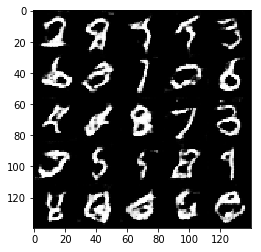

Epoch 2/2... Discriminator Loss: 0.5519... Generator Loss: 1.1543
Epoch 2/2... Discriminator Loss: 0.7176... Generator Loss: 0.8235
Epoch 2/2... Discriminator Loss: 0.6997... Generator Loss: 0.9713
Epoch 2/2... Discriminator Loss: 1.4872... Generator Loss: 0.3919
Epoch 2/2... Discriminator Loss: 0.2357... Generator Loss: 2.1714
Epoch 2/2... Discriminator Loss: 0.5688... Generator Loss: 2.9561
Epoch 2/2... Discriminator Loss: 2.6816... Generator Loss: 5.5310
Epoch 2/2... Discriminator Loss: 0.5359... Generator Loss: 3.5826
Epoch 2/2... Discriminator Loss: 0.3008... Generator Loss: 1.9492
Epoch 2/2... Discriminator Loss: 0.2507... Generator Loss: 1.7567


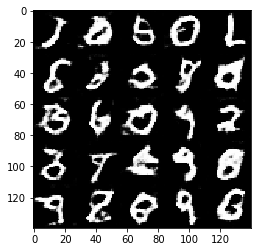

Epoch 2/2... Discriminator Loss: 0.2601... Generator Loss: 1.7380
Epoch 2/2... Discriminator Loss: 0.3564... Generator Loss: 1.5544
Epoch 2/2... Discriminator Loss: 0.5862... Generator Loss: 1.0139
Epoch 2/2... Discriminator Loss: 0.5118... Generator Loss: 1.2362
Epoch 2/2... Discriminator Loss: 0.5811... Generator Loss: 1.0608
Epoch 2/2... Discriminator Loss: 0.5081... Generator Loss: 1.1082
Epoch 2/2... Discriminator Loss: 0.5682... Generator Loss: 1.0830
Epoch 2/2... Discriminator Loss: 0.4662... Generator Loss: 1.3029
Epoch 2/2... Discriminator Loss: 0.9655... Generator Loss: 0.5911
Epoch 2/2... Discriminator Loss: 0.2976... Generator Loss: 1.7074


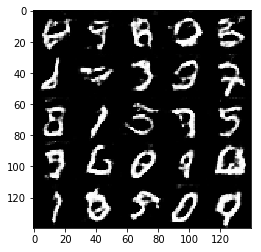

Epoch 2/2... Discriminator Loss: 0.5842... Generator Loss: 1.1079
Epoch 2/2... Discriminator Loss: 0.3996... Generator Loss: 1.3578
Epoch 2/2... Discriminator Loss: 0.6659... Generator Loss: 0.9310
Epoch 2/2... Discriminator Loss: 0.6529... Generator Loss: 1.0622
Epoch 2/2... Discriminator Loss: 0.3809... Generator Loss: 1.5809
Epoch 2/2... Discriminator Loss: 0.4408... Generator Loss: 1.2667
Epoch 2/2... Discriminator Loss: 0.6737... Generator Loss: 0.9528
Epoch 2/2... Discriminator Loss: 0.5825... Generator Loss: 1.0777
Epoch 2/2... Discriminator Loss: 0.5046... Generator Loss: 1.1898
Epoch 2/2... Discriminator Loss: 1.0580... Generator Loss: 0.6003


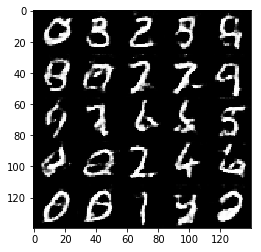

Epoch 2/2... Discriminator Loss: 0.4796... Generator Loss: 1.1672
Epoch 2/2... Discriminator Loss: 0.7003... Generator Loss: 1.0854
Epoch 2/2... Discriminator Loss: 0.8092... Generator Loss: 0.7085
Epoch 2/2... Discriminator Loss: 0.4237... Generator Loss: 1.4080
Epoch 2/2... Discriminator Loss: 0.3750... Generator Loss: 1.5225
Epoch 2/2... Discriminator Loss: 0.5731... Generator Loss: 1.0186
Epoch 2/2... Discriminator Loss: 0.4165... Generator Loss: 1.3454
Epoch 2/2... Discriminator Loss: 0.6124... Generator Loss: 1.0207
Epoch 2/2... Discriminator Loss: 0.4958... Generator Loss: 1.3563
Epoch 2/2... Discriminator Loss: 0.3790... Generator Loss: 1.4130


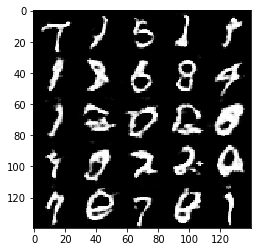

Epoch 2/2... Discriminator Loss: 0.9534... Generator Loss: 0.6910
Epoch 2/2... Discriminator Loss: 1.3274... Generator Loss: 0.4880
Epoch 2/2... Discriminator Loss: 0.4354... Generator Loss: 1.3292
Epoch 2/2... Discriminator Loss: 0.4213... Generator Loss: 1.2963
Epoch 2/2... Discriminator Loss: 0.4345... Generator Loss: 1.2930
Epoch 2/2... Discriminator Loss: 0.6655... Generator Loss: 1.0163
Epoch 2/2... Discriminator Loss: 0.5917... Generator Loss: 1.0457
Epoch 2/2... Discriminator Loss: 0.8958... Generator Loss: 0.7973
Epoch 2/2... Discriminator Loss: 0.7756... Generator Loss: 0.8920
Epoch 2/2... Discriminator Loss: 0.5999... Generator Loss: 1.1278


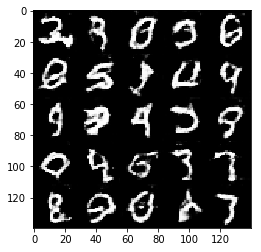

Epoch 2/2... Discriminator Loss: 0.8708... Generator Loss: 0.6964
Epoch 2/2... Discriminator Loss: 0.7024... Generator Loss: 0.8570
Epoch 2/2... Discriminator Loss: 0.6991... Generator Loss: 0.9298
Epoch 2/2... Discriminator Loss: 0.6574... Generator Loss: 1.0775
Epoch 2/2... Discriminator Loss: 0.6031... Generator Loss: 0.9325
Epoch 2/2... Discriminator Loss: 0.2320... Generator Loss: 1.9792
Epoch 2/2... Discriminator Loss: 0.5302... Generator Loss: 1.2685
Epoch 2/2... Discriminator Loss: 0.4640... Generator Loss: 1.2957
Epoch 2/2... Discriminator Loss: 0.5464... Generator Loss: 1.1078
Epoch 2/2... Discriminator Loss: 7.3700... Generator Loss: 10.4973


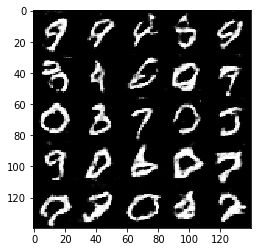

Epoch 2/2... Discriminator Loss: 0.7364... Generator Loss: 0.8229
Epoch 2/2... Discriminator Loss: 0.7601... Generator Loss: 1.0161
Epoch 2/2... Discriminator Loss: 0.4343... Generator Loss: 1.3555
Epoch 2/2... Discriminator Loss: 0.5695... Generator Loss: 1.0605
Epoch 2/2... Discriminator Loss: 0.3545... Generator Loss: 1.5228
Epoch 2/2... Discriminator Loss: 0.5898... Generator Loss: 1.1994
Epoch 2/2... Discriminator Loss: 0.3353... Generator Loss: 1.8318
Epoch 2/2... Discriminator Loss: 0.3747... Generator Loss: 1.5017
Epoch 2/2... Discriminator Loss: 0.6748... Generator Loss: 0.9025
Epoch 2/2... Discriminator Loss: 0.3208... Generator Loss: 1.6207


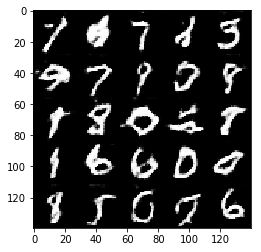

Epoch 2/2... Discriminator Loss: 0.6229... Generator Loss: 1.0123
Epoch 2/2... Discriminator Loss: 0.5262... Generator Loss: 1.1047
Epoch 2/2... Discriminator Loss: 1.1678... Generator Loss: 0.6226
Epoch 2/2... Discriminator Loss: 2.1857... Generator Loss: 0.2171
Epoch 2/2... Discriminator Loss: 0.4027... Generator Loss: 1.4919
Epoch 2/2... Discriminator Loss: 0.5453... Generator Loss: 1.1583
Epoch 2/2... Discriminator Loss: 0.3213... Generator Loss: 1.6207
Epoch 2/2... Discriminator Loss: 0.3040... Generator Loss: 1.8179
Epoch 2/2... Discriminator Loss: 0.3258... Generator Loss: 1.8045
Epoch 2/2... Discriminator Loss: 0.3135... Generator Loss: 1.7625


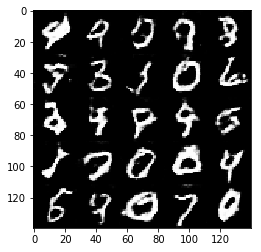

Epoch 2/2... Discriminator Loss: 0.5259... Generator Loss: 1.1004
Epoch 2/2... Discriminator Loss: 0.6664... Generator Loss: 0.9842
Epoch 2/2... Discriminator Loss: 0.5035... Generator Loss: 1.1429
Epoch 2/2... Discriminator Loss: 1.0900... Generator Loss: 0.6194
Epoch 2/2... Discriminator Loss: 0.6361... Generator Loss: 0.9241
Epoch 2/2... Discriminator Loss: 0.4662... Generator Loss: 1.3937
Epoch 2/2... Discriminator Loss: 0.3303... Generator Loss: 1.5118
Epoch 2/2... Discriminator Loss: 0.2221... Generator Loss: 3.4010
Epoch 2/2... Discriminator Loss: 0.4604... Generator Loss: 1.2215
Epoch 2/2... Discriminator Loss: 0.6049... Generator Loss: 1.0986


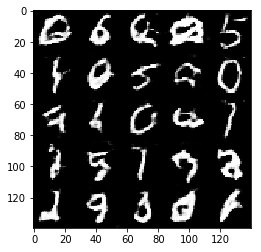

Epoch 2/2... Discriminator Loss: 0.3796... Generator Loss: 1.3891
Epoch 2/2... Discriminator Loss: 0.5613... Generator Loss: 1.1407
Epoch 2/2... Discriminator Loss: 0.3686... Generator Loss: 1.4238
Epoch 2/2... Discriminator Loss: 1.2502... Generator Loss: 0.5733
Epoch 2/2... Discriminator Loss: 0.4849... Generator Loss: 1.1333
Epoch 2/2... Discriminator Loss: 0.7829... Generator Loss: 0.8571
Epoch 2/2... Discriminator Loss: 2.4977... Generator Loss: 0.1784
Epoch 2/2... Discriminator Loss: 1.8423... Generator Loss: 0.2681
Epoch 2/2... Discriminator Loss: 0.3476... Generator Loss: 1.6149
Epoch 2/2... Discriminator Loss: 0.4349... Generator Loss: 1.2360


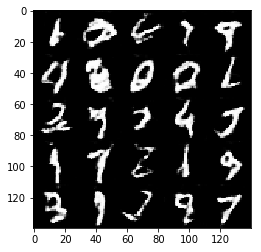

Epoch 2/2... Discriminator Loss: 0.3536... Generator Loss: 1.4952
Epoch 2/2... Discriminator Loss: 0.2191... Generator Loss: 2.8265
Epoch 2/2... Discriminator Loss: 0.5608... Generator Loss: 1.1736
Epoch 2/2... Discriminator Loss: 0.6871... Generator Loss: 1.0109
Epoch 2/2... Discriminator Loss: 0.4308... Generator Loss: 1.4790
Epoch 2/2... Discriminator Loss: 0.3458... Generator Loss: 1.6211
Epoch 2/2... Discriminator Loss: 0.2565... Generator Loss: 1.9725
Epoch 2/2... Discriminator Loss: 0.5504... Generator Loss: 1.2244
Epoch 2/2... Discriminator Loss: 0.4963... Generator Loss: 1.1930
Epoch 2/2... Discriminator Loss: 0.5768... Generator Loss: 1.0724


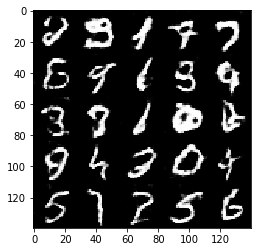

Epoch 2/2... Discriminator Loss: 0.4137... Generator Loss: 1.3749
Epoch 2/2... Discriminator Loss: 0.7810... Generator Loss: 0.8596
Epoch 2/2... Discriminator Loss: 0.2507... Generator Loss: 1.9239
Epoch 2/2... Discriminator Loss: 0.2115... Generator Loss: 1.9568
Epoch 2/2... Discriminator Loss: 0.3849... Generator Loss: 1.4187
Epoch 2/2... Discriminator Loss: 0.5287... Generator Loss: 1.3842
Epoch 2/2... Discriminator Loss: 0.5956... Generator Loss: 1.0464
Epoch 2/2... Discriminator Loss: 0.4428... Generator Loss: 1.4509
Epoch 2/2... Discriminator Loss: 0.5347... Generator Loss: 5.6792
Epoch 2/2... Discriminator Loss: 0.6084... Generator Loss: 1.0944


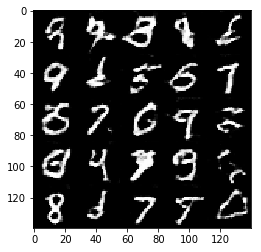

Epoch 2/2... Discriminator Loss: 0.3063... Generator Loss: 1.6664
Epoch 2/2... Discriminator Loss: 0.5042... Generator Loss: 1.2074
Epoch 2/2... Discriminator Loss: 0.4095... Generator Loss: 1.4478
Epoch 2/2... Discriminator Loss: 0.3844... Generator Loss: 1.4098
Epoch 2/2... Discriminator Loss: 0.4940... Generator Loss: 1.2548
Epoch 2/2... Discriminator Loss: 0.2747... Generator Loss: 1.7610
Epoch 2/2... Discriminator Loss: 0.6188... Generator Loss: 1.0163
Epoch 2/2... Discriminator Loss: 0.4650... Generator Loss: 1.3083
Epoch 2/2... Discriminator Loss: 0.4650... Generator Loss: 1.3591
Epoch 2/2... Discriminator Loss: 0.4863... Generator Loss: 1.2025


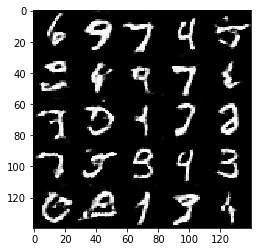

Epoch 2/2... Discriminator Loss: 0.1545... Generator Loss: 2.6471
Epoch 2/2... Discriminator Loss: 0.4578... Generator Loss: 1.2603
Epoch 2/2... Discriminator Loss: 1.6305... Generator Loss: 0.6040
Epoch 2/2... Discriminator Loss: 0.4237... Generator Loss: 1.4830
Epoch 2/2... Discriminator Loss: 0.2285... Generator Loss: 2.2100
Epoch 2/2... Discriminator Loss: 0.1886... Generator Loss: 2.7321
Epoch 2/2... Discriminator Loss: 1.0200... Generator Loss: 0.8772
Epoch 2/2... Discriminator Loss: 0.2948... Generator Loss: 2.0180
Epoch 2/2... Discriminator Loss: 0.9041... Generator Loss: 0.8843
Epoch 2/2... Discriminator Loss: 0.2049... Generator Loss: 2.2610


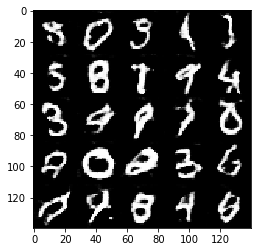

Epoch 2/2... Discriminator Loss: 0.7044... Generator Loss: 0.8947
Epoch 2/2... Discriminator Loss: 0.3136... Generator Loss: 1.5125
Epoch 2/2... Discriminator Loss: 0.3283... Generator Loss: 1.7339
Epoch 2/2... Discriminator Loss: 0.4614... Generator Loss: 1.4091
Epoch 2/2... Discriminator Loss: 0.5305... Generator Loss: 1.2917


In [20]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: -0.8374... Generator Loss: 1.1049
Epoch 1/1... Discriminator Loss: 0.5166... Generator Loss: 0.1411
Epoch 1/1... Discriminator Loss: -2.1110... Generator Loss: 4.5182
Epoch 1/1... Discriminator Loss: -0.8078... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: -1.3178... Generator Loss: 15.6584
Epoch 1/1... Discriminator Loss: -0.4032... Generator Loss: 1.4516
Epoch 1/1... Discriminator Loss: -1.3789... Generator Loss: 10.6243
Epoch 1/1... Discriminator Loss: 2.1685... Generator Loss: 18.4106
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 0.5632
Epoch 1/1... Discriminator Loss: -0.4476... Generator Loss: 1.9086


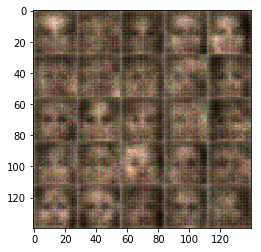

Epoch 1/1... Discriminator Loss: 2.6118... Generator Loss: 0.1541
Epoch 1/1... Discriminator Loss: -1.2829... Generator Loss: 3.8807
Epoch 1/1... Discriminator Loss: -0.2688... Generator Loss: 5.3241
Epoch 1/1... Discriminator Loss: -0.1348... Generator Loss: 1.0585
Epoch 1/1... Discriminator Loss: -0.0250... Generator Loss: 1.9001
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: -0.4517... Generator Loss: 1.5437
Epoch 1/1... Discriminator Loss: -0.6821... Generator Loss: 4.6598
Epoch 1/1... Discriminator Loss: -0.2873... Generator Loss: 1.8512
Epoch 1/1... Discriminator Loss: -0.6104... Generator Loss: 4.8333


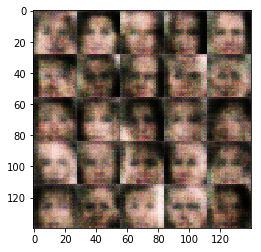

Epoch 1/1... Discriminator Loss: 0.1266... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 0.3724... Generator Loss: 0.9095
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: -0.6109... Generator Loss: 4.8662
Epoch 1/1... Discriminator Loss: 1.8914... Generator Loss: 0.1364
Epoch 1/1... Discriminator Loss: -0.4576... Generator Loss: 5.2727
Epoch 1/1... Discriminator Loss: 0.0675... Generator Loss: 2.3256
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.3113
Epoch 1/1... Discriminator Loss: 0.0942... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 0.8301... Generator Loss: 0.4877


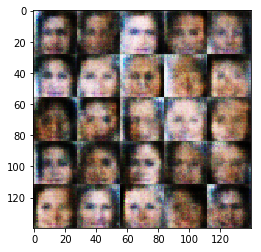

Epoch 1/1... Discriminator Loss: 0.7056... Generator Loss: 2.8242
Epoch 1/1... Discriminator Loss: 0.7691... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 0.0712... Generator Loss: 1.3609
Epoch 1/1... Discriminator Loss: 0.2136... Generator Loss: 4.1541
Epoch 1/1... Discriminator Loss: 0.3034... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 2.2350... Generator Loss: 0.0975
Epoch 1/1... Discriminator Loss: -0.2319... Generator Loss: 1.4593
Epoch 1/1... Discriminator Loss: 0.4831... Generator Loss: 1.9319
Epoch 1/1... Discriminator Loss: 0.1952... Generator Loss: 1.1497
Epoch 1/1... Discriminator Loss: 0.3495... Generator Loss: 1.0358


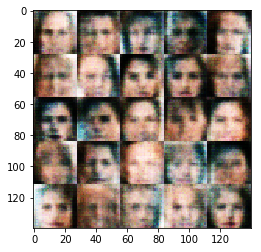

Epoch 1/1... Discriminator Loss: 0.2598... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 0.1830... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 0.5717
Epoch 1/1... Discriminator Loss: 0.3710... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 0.0858... Generator Loss: 3.2185
Epoch 1/1... Discriminator Loss: 0.3514... Generator Loss: 0.8924
Epoch 1/1... Discriminator Loss: 0.2834... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 0.0381... Generator Loss: 1.2395
Epoch 1/1... Discriminator Loss: 0.2851... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.3623


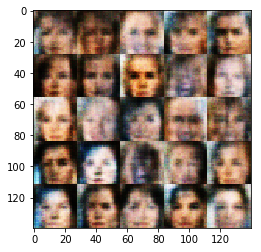

Epoch 1/1... Discriminator Loss: 0.0837... Generator Loss: 1.3165
Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 0.3530
Epoch 1/1... Discriminator Loss: 6.0726... Generator Loss: 8.7309
Epoch 1/1... Discriminator Loss: 0.3064... Generator Loss: 2.5750
Epoch 1/1... Discriminator Loss: 0.4414... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 0.0157... Generator Loss: 1.6590
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.1951
Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 0.4167
Epoch 1/1... Discriminator Loss: 0.3346... Generator Loss: 1.2415
Epoch 1/1... Discriminator Loss: 0.5955... Generator Loss: 0.7088


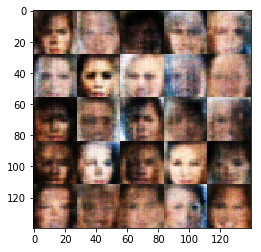

Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 0.3321
Epoch 1/1... Discriminator Loss: 0.5888... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 0.3489... Generator Loss: 3.5598
Epoch 1/1... Discriminator Loss: -0.1653... Generator Loss: 1.6532
Epoch 1/1... Discriminator Loss: 0.0663... Generator Loss: 1.0666
Epoch 1/1... Discriminator Loss: 0.1271... Generator Loss: 3.3229
Epoch 1/1... Discriminator Loss: 1.4803... Generator Loss: 0.3110
Epoch 1/1... Discriminator Loss: 0.8579... Generator Loss: 0.3874
Epoch 1/1... Discriminator Loss: 0.2244... Generator Loss: 1.3801
Epoch 1/1... Discriminator Loss: 1.9130... Generator Loss: 0.1613


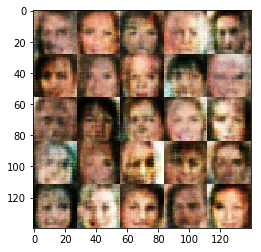

Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 0.3594
Epoch 1/1... Discriminator Loss: 1.5773... Generator Loss: 4.2770
Epoch 1/1... Discriminator Loss: 0.0493... Generator Loss: 2.3847
Epoch 1/1... Discriminator Loss: 0.2292... Generator Loss: 1.3636
Epoch 1/1... Discriminator Loss: 0.2177... Generator Loss: 1.1000
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 3.6098
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.2257
Epoch 1/1... Discriminator Loss: 0.2504... Generator Loss: 1.2527
Epoch 1/1... Discriminator Loss: 0.1530... Generator Loss: 1.9287
Epoch 1/1... Discriminator Loss: 2.2764... Generator Loss: 0.0772


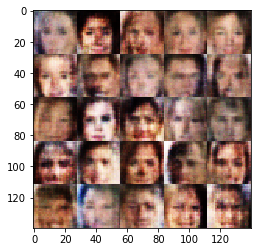

Epoch 1/1... Discriminator Loss: 0.3087... Generator Loss: 1.0172
Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 0.4877
Epoch 1/1... Discriminator Loss: 0.4141... Generator Loss: 1.1204
Epoch 1/1... Discriminator Loss: 1.6356... Generator Loss: 5.9055
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 0.3248
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 2.4857
Epoch 1/1... Discriminator Loss: 0.4986... Generator Loss: 1.2154
Epoch 1/1... Discriminator Loss: 0.1891... Generator Loss: 2.1805
Epoch 1/1... Discriminator Loss: 0.3849... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 0.2752... Generator Loss: 0.9048


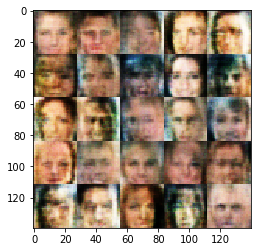

Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 0.4112
Epoch 1/1... Discriminator Loss: 0.3757... Generator Loss: 0.9799
Epoch 1/1... Discriminator Loss: 0.2853... Generator Loss: 2.6660
Epoch 1/1... Discriminator Loss: 0.7411... Generator Loss: 0.5305
Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 0.9845
Epoch 1/1... Discriminator Loss: 0.7197... Generator Loss: 0.4604
Epoch 1/1... Discriminator Loss: 0.5204... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 0.3714... Generator Loss: 2.2958
Epoch 1/1... Discriminator Loss: 0.4356... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 0.8445... Generator Loss: 0.3572


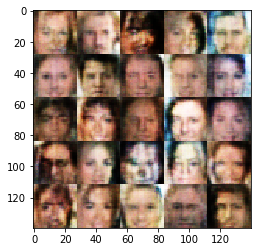

Epoch 1/1... Discriminator Loss: 0.2624... Generator Loss: 1.1861
Epoch 1/1... Discriminator Loss: 0.4793... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 0.2657... Generator Loss: 1.2268
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.2587
Epoch 1/1... Discriminator Loss: 0.3550... Generator Loss: 0.9960
Epoch 1/1... Discriminator Loss: 0.2853... Generator Loss: 1.7096
Epoch 1/1... Discriminator Loss: 0.1788... Generator Loss: 1.6848
Epoch 1/1... Discriminator Loss: 0.7424... Generator Loss: 0.4475
Epoch 1/1... Discriminator Loss: 0.7250... Generator Loss: 0.4907
Epoch 1/1... Discriminator Loss: 0.5224... Generator Loss: 0.6223


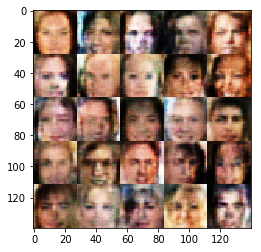

Epoch 1/1... Discriminator Loss: 0.8168... Generator Loss: 0.4474
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 0.3871
Epoch 1/1... Discriminator Loss: 0.6291... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 0.3846
Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 0.4285
Epoch 1/1... Discriminator Loss: 0.3227... Generator Loss: 1.2021
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.2589
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 0.2719
Epoch 1/1... Discriminator Loss: 0.2137... Generator Loss: 1.2751
Epoch 1/1... Discriminator Loss: 0.3919... Generator Loss: 1.4508


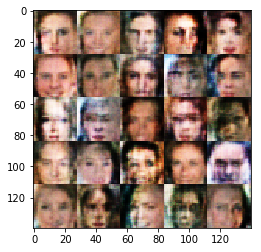

Epoch 1/1... Discriminator Loss: -0.0049... Generator Loss: 2.3706
Epoch 1/1... Discriminator Loss: 0.1278... Generator Loss: 1.2757
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 0.5102
Epoch 1/1... Discriminator Loss: 0.6247... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 0.1414... Generator Loss: 1.3947
Epoch 1/1... Discriminator Loss: -0.0405... Generator Loss: 1.2088
Epoch 1/1... Discriminator Loss: 0.1893... Generator Loss: 1.8194
Epoch 1/1... Discriminator Loss: 0.5931... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 0.3155
Epoch 1/1... Discriminator Loss: 0.3022... Generator Loss: 3.0931


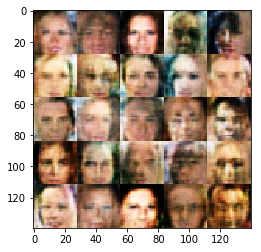

Epoch 1/1... Discriminator Loss: 0.6351... Generator Loss: 2.0965
Epoch 1/1... Discriminator Loss: 0.4562... Generator Loss: 1.3994
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.2491
Epoch 1/1... Discriminator Loss: 0.2331... Generator Loss: 1.0298
Epoch 1/1... Discriminator Loss: 0.4298... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 0.8373... Generator Loss: 2.5345
Epoch 1/1... Discriminator Loss: 0.8465... Generator Loss: 0.3391
Epoch 1/1... Discriminator Loss: 0.6844... Generator Loss: 3.3895
Epoch 1/1... Discriminator Loss: 0.4307... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: -0.0646... Generator Loss: 1.6842


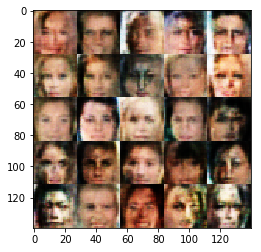

Epoch 1/1... Discriminator Loss: -0.0784... Generator Loss: 2.0901
Epoch 1/1... Discriminator Loss: 0.6517... Generator Loss: 2.2464
Epoch 1/1... Discriminator Loss: 0.8827... Generator Loss: 0.3649
Epoch 1/1... Discriminator Loss: 0.6039... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 0.3167... Generator Loss: 1.7042
Epoch 1/1... Discriminator Loss: 0.0221... Generator Loss: 1.4008
Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 0.4729
Epoch 1/1... Discriminator Loss: 0.5816... Generator Loss: 1.5614
Epoch 1/1... Discriminator Loss: 0.6511... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 0.2072... Generator Loss: 1.0193


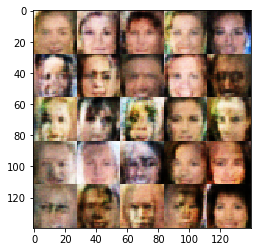

Epoch 1/1... Discriminator Loss: 0.6891... Generator Loss: 0.5255
Epoch 1/1... Discriminator Loss: 0.6743... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 0.8453... Generator Loss: 0.4995
Epoch 1/1... Discriminator Loss: 0.3165... Generator Loss: 1.2400
Epoch 1/1... Discriminator Loss: 0.1296... Generator Loss: 1.3626
Epoch 1/1... Discriminator Loss: 0.7634... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 0.5133... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 0.2683... Generator Loss: 2.0486
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 0.3817
Epoch 1/1... Discriminator Loss: 0.2546... Generator Loss: 1.1223


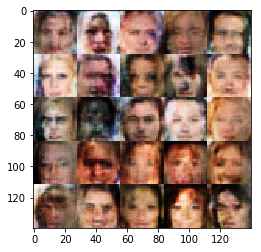

Epoch 1/1... Discriminator Loss: 0.1885... Generator Loss: 2.4824
Epoch 1/1... Discriminator Loss: 1.8862... Generator Loss: 0.1041
Epoch 1/1... Discriminator Loss: 0.3090... Generator Loss: 0.9685
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 0.4550
Epoch 1/1... Discriminator Loss: 0.2106... Generator Loss: 1.3647
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 0.3459
Epoch 1/1... Discriminator Loss: 0.5619... Generator Loss: 0.6240
Epoch 1/1... Discriminator Loss: 0.9359... Generator Loss: 0.4307
Epoch 1/1... Discriminator Loss: 0.8981... Generator Loss: 0.3429
Epoch 1/1... Discriminator Loss: 0.2169... Generator Loss: 1.2002


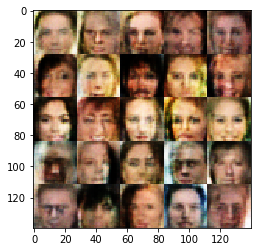

Epoch 1/1... Discriminator Loss: 0.6017... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 0.9394... Generator Loss: 0.4799
Epoch 1/1... Discriminator Loss: 0.7242... Generator Loss: 2.6372
Epoch 1/1... Discriminator Loss: 0.4995... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 0.0235... Generator Loss: 1.4007
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.3076
Epoch 1/1... Discriminator Loss: 0.3509... Generator Loss: 2.6120
Epoch 1/1... Discriminator Loss: 0.0279... Generator Loss: 1.9752
Epoch 1/1... Discriminator Loss: 0.7472... Generator Loss: 2.9017
Epoch 1/1... Discriminator Loss: 0.2739... Generator Loss: 1.6340


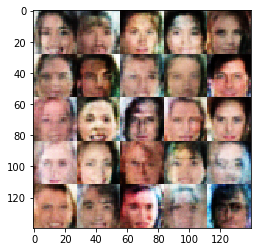

Epoch 1/1... Discriminator Loss: 0.3212... Generator Loss: 0.9797
Epoch 1/1... Discriminator Loss: 2.1972... Generator Loss: 0.0823
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 0.3793
Epoch 1/1... Discriminator Loss: 0.2327... Generator Loss: 2.3992
Epoch 1/1... Discriminator Loss: 0.1521... Generator Loss: 0.9751
Epoch 1/1... Discriminator Loss: 0.4615... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.6778... Generator Loss: 0.2045
Epoch 1/1... Discriminator Loss: 0.6747... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.2217
Epoch 1/1... Discriminator Loss: 0.0946... Generator Loss: 1.1345


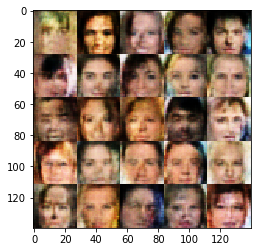

Epoch 1/1... Discriminator Loss: 0.5701... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.3007
Epoch 1/1... Discriminator Loss: 0.5620... Generator Loss: 0.6423
Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 0.1662
Epoch 1/1... Discriminator Loss: 0.6343... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 0.7883... Generator Loss: 0.5350
Epoch 1/1... Discriminator Loss: 0.0323... Generator Loss: 2.1402
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.2987
Epoch 1/1... Discriminator Loss: 0.2289... Generator Loss: 1.3731
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 0.3167


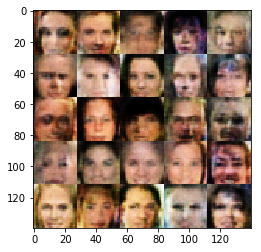

Epoch 1/1... Discriminator Loss: 1.6052... Generator Loss: 0.2008
Epoch 1/1... Discriminator Loss: 0.3383... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.3463
Epoch 1/1... Discriminator Loss: 2.2307... Generator Loss: 0.0949
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.2187
Epoch 1/1... Discriminator Loss: 0.6126... Generator Loss: 0.5311
Epoch 1/1... Discriminator Loss: 0.7192... Generator Loss: 1.9511
Epoch 1/1... Discriminator Loss: 0.0978... Generator Loss: 1.5748
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.2063
Epoch 1/1... Discriminator Loss: 0.3464... Generator Loss: 0.8483


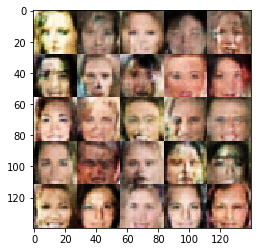

Epoch 1/1... Discriminator Loss: -0.0911... Generator Loss: 1.1887
Epoch 1/1... Discriminator Loss: 0.4727... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 0.1200... Generator Loss: 1.0607
Epoch 1/1... Discriminator Loss: 1.5147... Generator Loss: 0.2193
Epoch 1/1... Discriminator Loss: 0.5220... Generator Loss: 3.0512
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.2462
Epoch 1/1... Discriminator Loss: 0.6647... Generator Loss: 0.5086
Epoch 1/1... Discriminator Loss: 0.0875... Generator Loss: 1.3567
Epoch 1/1... Discriminator Loss: 1.6771... Generator Loss: 0.1489
Epoch 1/1... Discriminator Loss: 0.2572... Generator Loss: 2.6382


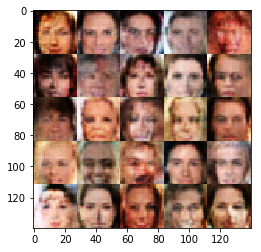

Epoch 1/1... Discriminator Loss: 0.0176... Generator Loss: 1.4863
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.2097
Epoch 1/1... Discriminator Loss: 0.8969... Generator Loss: 0.4703
Epoch 1/1... Discriminator Loss: 1.9101... Generator Loss: 0.2123
Epoch 1/1... Discriminator Loss: 0.9504... Generator Loss: 0.4596
Epoch 1/1... Discriminator Loss: 0.5476... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 0.3932... Generator Loss: 1.3361
Epoch 1/1... Discriminator Loss: 0.5027... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 0.4792... Generator Loss: 1.0764
Epoch 1/1... Discriminator Loss: 0.0495... Generator Loss: 1.3983


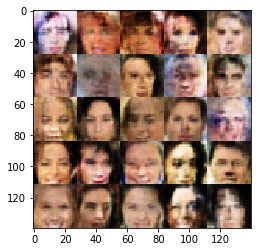

Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.2923
Epoch 1/1... Discriminator Loss: 0.8943... Generator Loss: 0.4171
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.3062
Epoch 1/1... Discriminator Loss: 0.5186... Generator Loss: 0.6101
Epoch 1/1... Discriminator Loss: 1.5680... Generator Loss: 0.2067
Epoch 1/1... Discriminator Loss: 0.4375... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.8785... Generator Loss: 0.1097
Epoch 1/1... Discriminator Loss: 0.9107... Generator Loss: 0.4321
Epoch 1/1... Discriminator Loss: 0.5401... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.7556... Generator Loss: 0.1240


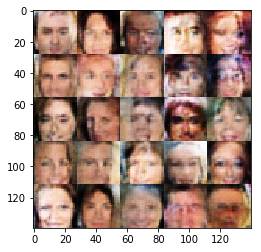

Epoch 1/1... Discriminator Loss: 0.3567... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 0.7836... Generator Loss: 0.4824
Epoch 1/1... Discriminator Loss: 0.2589... Generator Loss: 4.0285
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 0.3249
Epoch 1/1... Discriminator Loss: 2.2723... Generator Loss: 0.0991
Epoch 1/1... Discriminator Loss: 0.3703... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 0.0727... Generator Loss: 1.9404
Epoch 1/1... Discriminator Loss: -0.0090... Generator Loss: 2.5634
Epoch 1/1... Discriminator Loss: -0.1989... Generator Loss: 1.1954
Epoch 1/1... Discriminator Loss: 0.2925... Generator Loss: 1.1776


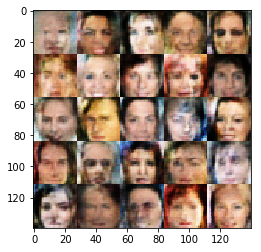

Epoch 1/1... Discriminator Loss: 0.2941... Generator Loss: 0.9583
Epoch 1/1... Discriminator Loss: 1.5739... Generator Loss: 0.1808
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 0.3900
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.3119
Epoch 1/1... Discriminator Loss: 0.3598... Generator Loss: 1.0753
Epoch 1/1... Discriminator Loss: 0.0964... Generator Loss: 2.8652
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.2729
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 0.3765
Epoch 1/1... Discriminator Loss: -0.1637... Generator Loss: 2.1418
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.1621


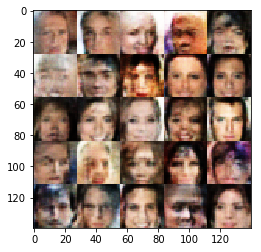

Epoch 1/1... Discriminator Loss: 0.2415... Generator Loss: 0.9928
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.2295
Epoch 1/1... Discriminator Loss: 0.7550... Generator Loss: 0.4939
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.3504
Epoch 1/1... Discriminator Loss: 0.2603... Generator Loss: 1.4511
Epoch 1/1... Discriminator Loss: 0.2840... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 0.2685... Generator Loss: 1.1112
Epoch 1/1... Discriminator Loss: 0.2165... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 3.4643
Epoch 1/1... Discriminator Loss: 0.3431... Generator Loss: 0.7148


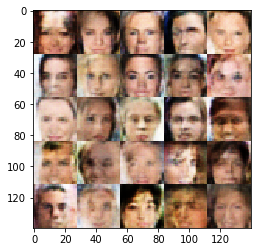

Epoch 1/1... Discriminator Loss: 1.8417... Generator Loss: 0.1243
Epoch 1/1... Discriminator Loss: 0.8633... Generator Loss: 0.3557
Epoch 1/1... Discriminator Loss: 0.2870... Generator Loss: 1.0619
Epoch 1/1... Discriminator Loss: 1.6272... Generator Loss: 3.5462
Epoch 1/1... Discriminator Loss: 0.1216... Generator Loss: 1.4842
Epoch 1/1... Discriminator Loss: 0.0133... Generator Loss: 1.6179
Epoch 1/1... Discriminator Loss: 0.3293... Generator Loss: 1.0260
Epoch 1/1... Discriminator Loss: 0.3688... Generator Loss: 1.3371
Epoch 1/1... Discriminator Loss: -0.1139... Generator Loss: 1.7983
Epoch 1/1... Discriminator Loss: 2.0658... Generator Loss: 0.1027


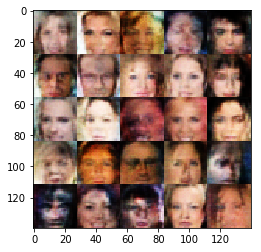

Epoch 1/1... Discriminator Loss: 0.2833... Generator Loss: 1.0374
Epoch 1/1... Discriminator Loss: 0.5033... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 0.2135... Generator Loss: 1.3322
Epoch 1/1... Discriminator Loss: 1.7398... Generator Loss: 0.1437
Epoch 1/1... Discriminator Loss: 0.2403... Generator Loss: 1.1954
Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 0.3802
Epoch 1/1... Discriminator Loss: 0.1773... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: -0.0527... Generator Loss: 1.3926
Epoch 1/1... Discriminator Loss: -0.1684... Generator Loss: 1.8287


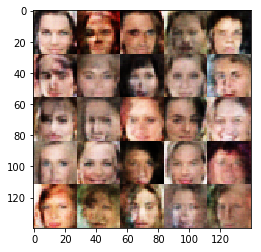

Epoch 1/1... Discriminator Loss: 0.2734... Generator Loss: 1.2623
Epoch 1/1... Discriminator Loss: 0.3366... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 0.2460... Generator Loss: 3.4726
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 4.5339
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.3653
Epoch 1/1... Discriminator Loss: 0.4696... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 0.7990... Generator Loss: 0.5137
Epoch 1/1... Discriminator Loss: 0.5643... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 0.4470... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.7464... Generator Loss: 0.1728


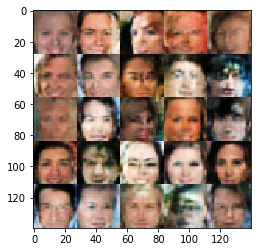

Epoch 1/1... Discriminator Loss: 0.5850... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 0.8375... Generator Loss: 0.4243
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.2249
Epoch 1/1... Discriminator Loss: 0.2174... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 0.1269... Generator Loss: 1.0828
Epoch 1/1... Discriminator Loss: 0.2044... Generator Loss: 0.9912
Epoch 1/1... Discriminator Loss: -0.0365... Generator Loss: 1.8062
Epoch 1/1... Discriminator Loss: 0.4581... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 0.9978... Generator Loss: 0.3355
Epoch 1/1... Discriminator Loss: 2.4041... Generator Loss: 0.0646


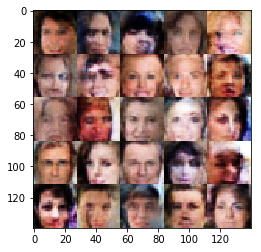

Epoch 1/1... Discriminator Loss: 0.5260... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 0.1516... Generator Loss: 1.9189
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.2941
Epoch 1/1... Discriminator Loss: 0.5887... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 0.2791... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 0.2489... Generator Loss: 1.6705
Epoch 1/1... Discriminator Loss: 2.1088... Generator Loss: 0.1153
Epoch 1/1... Discriminator Loss: 0.2544... Generator Loss: 2.1304
Epoch 1/1... Discriminator Loss: 0.5179... Generator Loss: 2.1319
Epoch 1/1... Discriminator Loss: 0.5753... Generator Loss: 0.7125


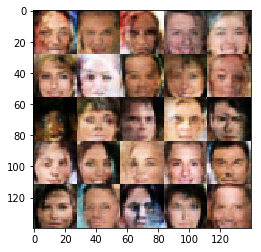

Epoch 1/1... Discriminator Loss: 0.7282... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 0.2875... Generator Loss: 0.9740
Epoch 1/1... Discriminator Loss: 2.4973... Generator Loss: 0.0936
Epoch 1/1... Discriminator Loss: 0.5061... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 0.4198
Epoch 1/1... Discriminator Loss: -0.0346... Generator Loss: 1.2559
Epoch 1/1... Discriminator Loss: 0.3547... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 0.3631
Epoch 1/1... Discriminator Loss: 0.1099... Generator Loss: 1.7516
Epoch 1/1... Discriminator Loss: 1.6099... Generator Loss: 0.1875


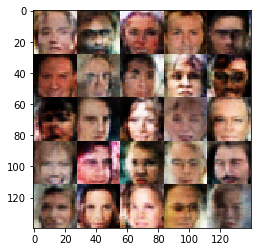

Epoch 1/1... Discriminator Loss: 0.5203... Generator Loss: 1.3423
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 0.3484
Epoch 1/1... Discriminator Loss: 1.6758... Generator Loss: 0.1741
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.2267
Epoch 1/1... Discriminator Loss: 2.9542... Generator Loss: 5.5838
Epoch 1/1... Discriminator Loss: 0.0635... Generator Loss: 1.2340
Epoch 1/1... Discriminator Loss: 1.6045... Generator Loss: 0.2047
Epoch 1/1... Discriminator Loss: 0.3860... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: -0.0542... Generator Loss: 1.1490
Epoch 1/1... Discriminator Loss: 0.2789... Generator Loss: 1.0345


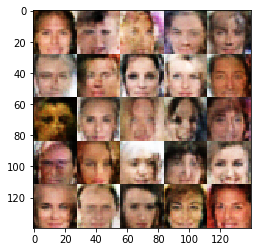

Epoch 1/1... Discriminator Loss: 0.0866... Generator Loss: 2.4783
Epoch 1/1... Discriminator Loss: 0.3671... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 2.6671... Generator Loss: 0.0570
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.1908
Epoch 1/1... Discriminator Loss: 0.3983... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 0.2453... Generator Loss: 0.9914
Epoch 1/1... Discriminator Loss: 2.2858... Generator Loss: 0.1284
Epoch 1/1... Discriminator Loss: 0.7197... Generator Loss: 0.4738
Epoch 1/1... Discriminator Loss: 0.2095... Generator Loss: 1.1556
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.2275


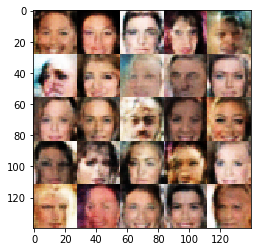

Epoch 1/1... Discriminator Loss: 1.8840... Generator Loss: 0.1292
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.3284
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 0.2927
Epoch 1/1... Discriminator Loss: 0.5965... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 0.2704... Generator Loss: 0.8879
Epoch 1/1... Discriminator Loss: 0.0892... Generator Loss: 1.3717
Epoch 1/1... Discriminator Loss: 0.7394... Generator Loss: 0.4693
Epoch 1/1... Discriminator Loss: 0.7257... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.3210
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 5.3610


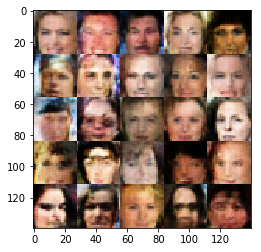

Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.3045
Epoch 1/1... Discriminator Loss: 0.8493... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 0.3178... Generator Loss: 0.9750
Epoch 1/1... Discriminator Loss: 0.2298... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 0.2704... Generator Loss: 1.4438
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.1871
Epoch 1/1... Discriminator Loss: 0.1518... Generator Loss: 2.6492
Epoch 1/1... Discriminator Loss: 2.1569... Generator Loss: 0.1014
Epoch 1/1... Discriminator Loss: 0.2193... Generator Loss: 0.9873
Epoch 1/1... Discriminator Loss: 0.2156... Generator Loss: 0.9270


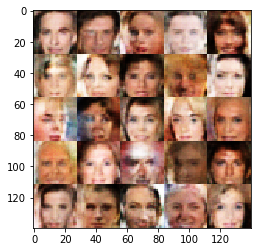

Epoch 1/1... Discriminator Loss: 2.0320... Generator Loss: 0.1312
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 0.3575
Epoch 1/1... Discriminator Loss: 1.5850... Generator Loss: 0.2048
Epoch 1/1... Discriminator Loss: 0.7221... Generator Loss: 0.5065
Epoch 1/1... Discriminator Loss: 0.2120... Generator Loss: 1.2924
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 4.5572
Epoch 1/1... Discriminator Loss: 0.5860... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 0.8017... Generator Loss: 0.4572
Epoch 1/1... Discriminator Loss: 0.4636... Generator Loss: 1.2921
Epoch 1/1... Discriminator Loss: 0.2302... Generator Loss: 0.9237


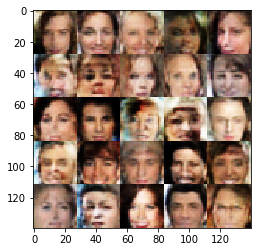

Epoch 1/1... Discriminator Loss: -0.0227... Generator Loss: 3.5532
Epoch 1/1... Discriminator Loss: 0.6921... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 0.5376... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 0.2629... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.2419
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 0.3029
Epoch 1/1... Discriminator Loss: 0.6744... Generator Loss: 0.4862
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.3214
Epoch 1/1... Discriminator Loss: 0.1014... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 5.6680


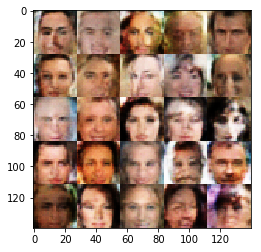

Epoch 1/1... Discriminator Loss: -0.0974... Generator Loss: 1.9519
Epoch 1/1... Discriminator Loss: 0.7788... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 0.5505... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 0.3860
Epoch 1/1... Discriminator Loss: 0.4354... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 0.1125... Generator Loss: 1.2309
Epoch 1/1... Discriminator Loss: 0.6940... Generator Loss: 0.5544
Epoch 1/1... Discriminator Loss: 0.3010... Generator Loss: 0.9493
Epoch 1/1... Discriminator Loss: 0.9079... Generator Loss: 0.4306
Epoch 1/1... Discriminator Loss: 1.7870... Generator Loss: 0.1556


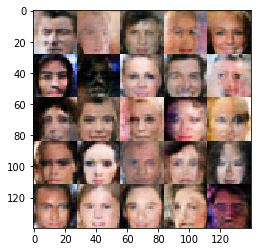

Epoch 1/1... Discriminator Loss: 0.9508... Generator Loss: 0.4094
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 0.3605
Epoch 1/1... Discriminator Loss: 0.4310... Generator Loss: 1.2325
Epoch 1/1... Discriminator Loss: 0.4985... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 0.0219... Generator Loss: 3.2377
Epoch 1/1... Discriminator Loss: 0.1700... Generator Loss: 0.9852
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 0.5091
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 0.2947
Epoch 1/1... Discriminator Loss: 0.2703... Generator Loss: 4.1905
Epoch 1/1... Discriminator Loss: 3.8183... Generator Loss: 0.0245


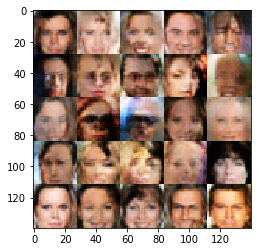

Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 0.4574
Epoch 1/1... Discriminator Loss: 0.6048... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: -0.1881... Generator Loss: 1.7326
Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 0.1907
Epoch 1/1... Discriminator Loss: 0.4769... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 2.3295... Generator Loss: 0.0823
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.3272
Epoch 1/1... Discriminator Loss: 0.0518... Generator Loss: 1.3725
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.2758
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.2393


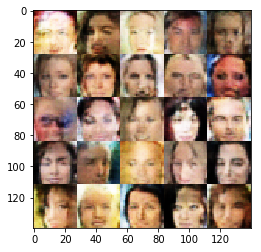

Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.3873
Epoch 1/1... Discriminator Loss: 1.5460... Generator Loss: 0.1992
Epoch 1/1... Discriminator Loss: 0.5055... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.2882
Epoch 1/1... Discriminator Loss: 1.6723... Generator Loss: 0.2050
Epoch 1/1... Discriminator Loss: -0.0130... Generator Loss: 1.3215
Epoch 1/1... Discriminator Loss: -0.0827... Generator Loss: 2.3872
Epoch 1/1... Discriminator Loss: 0.8885... Generator Loss: 0.4689
Epoch 1/1... Discriminator Loss: 0.7606... Generator Loss: 4.2484
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.2919


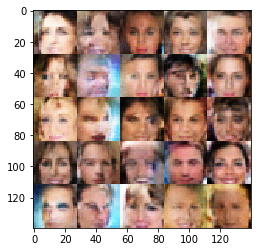

Epoch 1/1... Discriminator Loss: 0.8466... Generator Loss: 0.5326
Epoch 1/1... Discriminator Loss: 0.0704... Generator Loss: 2.1765
Epoch 1/1... Discriminator Loss: 0.0996... Generator Loss: 2.0285
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 4.1152
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.3068
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.1791
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.3477
Epoch 1/1... Discriminator Loss: 0.3912... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 0.8994... Generator Loss: 0.4785
Epoch 1/1... Discriminator Loss: 1.0287... Generator Loss: 0.3168


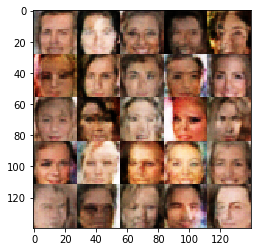

Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.2777
Epoch 1/1... Discriminator Loss: 0.5797... Generator Loss: 0.5841
Epoch 1/1... Discriminator Loss: 1.8705... Generator Loss: 0.1579
Epoch 1/1... Discriminator Loss: 0.3494... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.2287
Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 3.4930
Epoch 1/1... Discriminator Loss: 0.6731... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 0.1408... Generator Loss: 1.1007
Epoch 1/1... Discriminator Loss: 0.8368... Generator Loss: 0.4648
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 3.9089


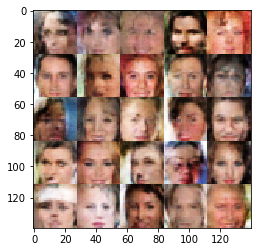

Epoch 1/1... Discriminator Loss: 0.7468... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 0.3857... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 0.0769... Generator Loss: 1.6132
Epoch 1/1... Discriminator Loss: 0.2141... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: -0.1284... Generator Loss: 2.9317
Epoch 1/1... Discriminator Loss: 0.2181... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.9598... Generator Loss: 0.1682
Epoch 1/1... Discriminator Loss: 0.5136... Generator Loss: 3.6180
Epoch 1/1... Discriminator Loss: 2.1162... Generator Loss: 0.0908
Epoch 1/1... Discriminator Loss: 0.1906... Generator Loss: 1.0975


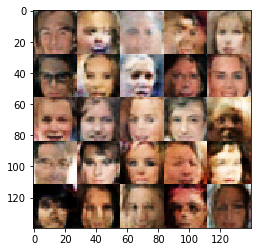

Epoch 1/1... Discriminator Loss: 0.9428... Generator Loss: 0.4201
Epoch 1/1... Discriminator Loss: 0.9151... Generator Loss: 0.4592
Epoch 1/1... Discriminator Loss: 0.7101... Generator Loss: 0.5116
Epoch 1/1... Discriminator Loss: 0.8082... Generator Loss: 0.4055
Epoch 1/1... Discriminator Loss: 0.6146... Generator Loss: 0.5623
Epoch 1/1... Discriminator Loss: 0.7151... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 0.3416... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: -0.0183... Generator Loss: 1.3182
Epoch 1/1... Discriminator Loss: 1.8430... Generator Loss: 0.1339
Epoch 1/1... Discriminator Loss: 0.3884... Generator Loss: 0.6823


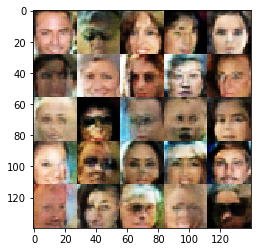

Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.2789
Epoch 1/1... Discriminator Loss: 0.9029... Generator Loss: 0.3868
Epoch 1/1... Discriminator Loss: 0.5508... Generator Loss: 0.5558
Epoch 1/1... Discriminator Loss: 0.4482... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: -0.0469... Generator Loss: 1.0318
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 4.3096
Epoch 1/1... Discriminator Loss: 0.6530... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 0.2894... Generator Loss: 0.9257
Epoch 1/1... Discriminator Loss: 0.0524... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 1.6409... Generator Loss: 0.1962


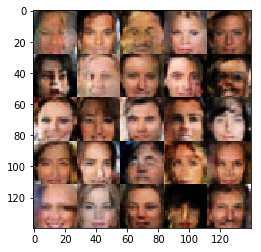

Epoch 1/1... Discriminator Loss: 1.9331... Generator Loss: 0.1218
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 0.3553
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 0.3250
Epoch 1/1... Discriminator Loss: 1.7002... Generator Loss: 0.1683
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 0.3654
Epoch 1/1... Discriminator Loss: 0.7893... Generator Loss: 0.3853
Epoch 1/1... Discriminator Loss: 0.5332... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.2910
Epoch 1/1... Discriminator Loss: 0.5423... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.9486... Generator Loss: 0.1318


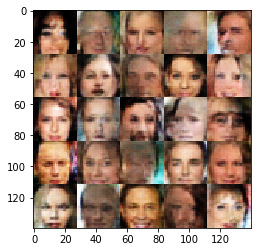

Epoch 1/1... Discriminator Loss: 0.1458... Generator Loss: 1.4216
Epoch 1/1... Discriminator Loss: 0.1416... Generator Loss: 1.1602
Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 0.1868
Epoch 1/1... Discriminator Loss: 0.0880... Generator Loss: 1.3173
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.2635
Epoch 1/1... Discriminator Loss: 0.8447... Generator Loss: 0.4102
Epoch 1/1... Discriminator Loss: -0.4822... Generator Loss: 3.4770
Epoch 1/1... Discriminator Loss: 0.2610... Generator Loss: 1.0597
Epoch 1/1... Discriminator Loss: 0.2682... Generator Loss: 1.1505
Epoch 1/1... Discriminator Loss: 5.2468... Generator Loss: 0.0226


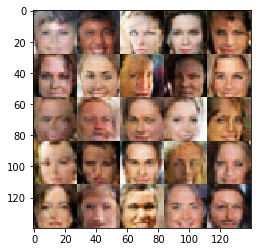

Epoch 1/1... Discriminator Loss: 0.2268... Generator Loss: 2.9752
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 0.4254
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.2833
Epoch 1/1... Discriminator Loss: 0.0617... Generator Loss: 2.7246
Epoch 1/1... Discriminator Loss: 0.7027... Generator Loss: 0.4331
Epoch 1/1... Discriminator Loss: -0.1682... Generator Loss: 1.5088
Epoch 1/1... Discriminator Loss: 1.8652... Generator Loss: 0.1333
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.3135
Epoch 1/1... Discriminator Loss: 0.3627... Generator Loss: 0.9398
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 0.3056


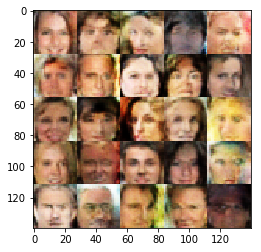

Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.3448
Epoch 1/1... Discriminator Loss: 0.7501... Generator Loss: 0.4826
Epoch 1/1... Discriminator Loss: 0.7095... Generator Loss: 0.5742
Epoch 1/1... Discriminator Loss: 0.3179... Generator Loss: 3.9739
Epoch 1/1... Discriminator Loss: 0.0722... Generator Loss: 1.4056
Epoch 1/1... Discriminator Loss: 0.2130... Generator Loss: 2.8009
Epoch 1/1... Discriminator Loss: 0.4772... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 0.8065... Generator Loss: 0.4773
Epoch 1/1... Discriminator Loss: 0.4216... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 0.4215


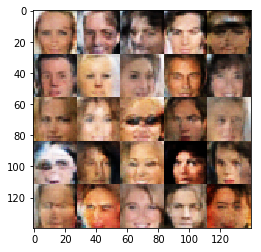

Epoch 1/1... Discriminator Loss: 0.5440... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 0.1679... Generator Loss: 3.0926
Epoch 1/1... Discriminator Loss: 0.0118... Generator Loss: 2.5194
Epoch 1/1... Discriminator Loss: 0.6454... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 0.3985
Epoch 1/1... Discriminator Loss: 0.3681... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 0.3390
Epoch 1/1... Discriminator Loss: 0.4816... Generator Loss: 1.1389
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.2587
Epoch 1/1... Discriminator Loss: 2.4511... Generator Loss: 0.0904


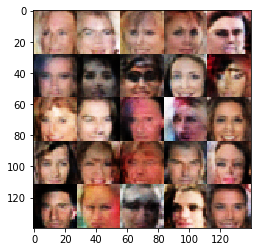

Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 0.3993
Epoch 1/1... Discriminator Loss: 1.9293... Generator Loss: 0.1086
Epoch 1/1... Discriminator Loss: 0.4080... Generator Loss: 1.0874
Epoch 1/1... Discriminator Loss: 0.7374... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 0.0137... Generator Loss: 1.0418
Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 0.3575
Epoch 1/1... Discriminator Loss: 1.6205... Generator Loss: 0.1473
Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 0.5771
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.3005
Epoch 1/1... Discriminator Loss: 0.3589... Generator Loss: 1.1042


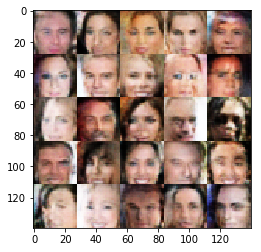

Epoch 1/1... Discriminator Loss: 0.0994... Generator Loss: 2.1937
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.2065
Epoch 1/1... Discriminator Loss: 0.0304... Generator Loss: 1.1388
Epoch 1/1... Discriminator Loss: 0.2659... Generator Loss: 1.4069
Epoch 1/1... Discriminator Loss: -0.0422... Generator Loss: 1.6633
Epoch 1/1... Discriminator Loss: -0.1478... Generator Loss: 1.6582
Epoch 1/1... Discriminator Loss: 0.1892... Generator Loss: 2.6592
Epoch 1/1... Discriminator Loss: 1.7282... Generator Loss: 0.1482
Epoch 1/1... Discriminator Loss: 0.5818... Generator Loss: 0.5695
Epoch 1/1... Discriminator Loss: 0.6055... Generator Loss: 3.8407


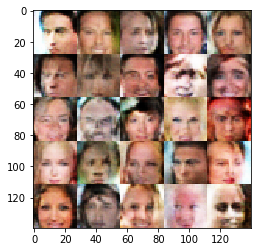

Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 0.3821
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.3495
Epoch 1/1... Discriminator Loss: 0.1782... Generator Loss: 2.2372
Epoch 1/1... Discriminator Loss: 0.5496... Generator Loss: 3.3817
Epoch 1/1... Discriminator Loss: 0.4691... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 0.3980... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 0.6697... Generator Loss: 0.5026
Epoch 1/1... Discriminator Loss: -0.0604... Generator Loss: 1.5414
Epoch 1/1... Discriminator Loss: 0.8866... Generator Loss: 0.4357
Epoch 1/1... Discriminator Loss: 0.6453... Generator Loss: 0.5579


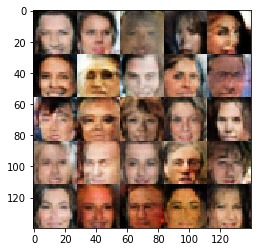

Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 1.4118
Epoch 1/1... Discriminator Loss: 0.0111... Generator Loss: 1.0889
Epoch 1/1... Discriminator Loss: 1.9565... Generator Loss: 0.0993
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.3349
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.2632
Epoch 1/1... Discriminator Loss: 2.3422... Generator Loss: 0.1211
Epoch 1/1... Discriminator Loss: 1.9301... Generator Loss: 0.1561
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.2730
Epoch 1/1... Discriminator Loss: 0.4620... Generator Loss: 0.5639
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.3952


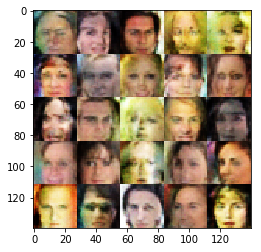

Epoch 1/1... Discriminator Loss: 0.3764... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: -0.0968... Generator Loss: 2.2245
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.3279
Epoch 1/1... Discriminator Loss: 1.8707... Generator Loss: 0.1565
Epoch 1/1... Discriminator Loss: 0.3489... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 0.8145... Generator Loss: 0.5308
Epoch 1/1... Discriminator Loss: 0.1776... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 0.4470
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 0.3981
Epoch 1/1... Discriminator Loss: 0.7932... Generator Loss: 0.4267


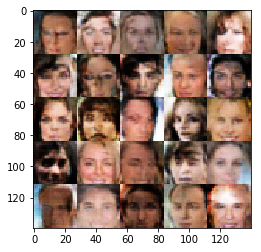

Epoch 1/1... Discriminator Loss: 0.3110... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 2.7439... Generator Loss: 0.0551
Epoch 1/1... Discriminator Loss: 0.4688... Generator Loss: 2.1474
Epoch 1/1... Discriminator Loss: 0.3979... Generator Loss: 0.9450
Epoch 1/1... Discriminator Loss: 0.2488... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.2857
Epoch 1/1... Discriminator Loss: 0.4946... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 0.6697... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 0.1605... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 0.7050... Generator Loss: 0.5297


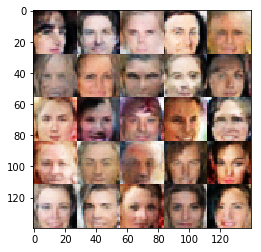

Epoch 1/1... Discriminator Loss: 0.5437... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.9224... Generator Loss: 0.1315
Epoch 1/1... Discriminator Loss: 2.1188... Generator Loss: 0.1404
Epoch 1/1... Discriminator Loss: 0.1188... Generator Loss: 3.0986
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.2432
Epoch 1/1... Discriminator Loss: 0.6187... Generator Loss: 0.4759
Epoch 1/1... Discriminator Loss: 0.6284... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 0.4939
Epoch 1/1... Discriminator Loss: -0.4973... Generator Loss: 3.2055
Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 0.4467


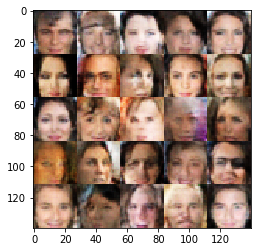

Epoch 1/1... Discriminator Loss: 0.0208... Generator Loss: 1.7723
Epoch 1/1... Discriminator Loss: 0.4149... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 0.4592... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.5502... Generator Loss: 0.2013
Epoch 1/1... Discriminator Loss: 0.4230... Generator Loss: 1.9954
Epoch 1/1... Discriminator Loss: 0.8756... Generator Loss: 0.3743
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.3652
Epoch 1/1... Discriminator Loss: 0.0733... Generator Loss: 1.4121
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 0.3823
Epoch 1/1... Discriminator Loss: 0.2982... Generator Loss: 0.8608


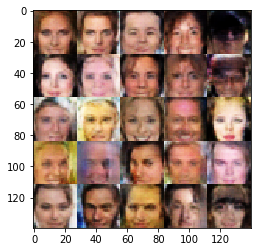

Epoch 1/1... Discriminator Loss: 0.7054... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 0.7656... Generator Loss: 0.4678
Epoch 1/1... Discriminator Loss: 0.0464... Generator Loss: 1.6843
Epoch 1/1... Discriminator Loss: 0.7288... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 2.4354... Generator Loss: 0.0646
Epoch 1/1... Discriminator Loss: 0.1758... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.4018
Epoch 1/1... Discriminator Loss: 0.0806... Generator Loss: 1.8210
Epoch 1/1... Discriminator Loss: 0.1968... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 2.3398... Generator Loss: 0.1743


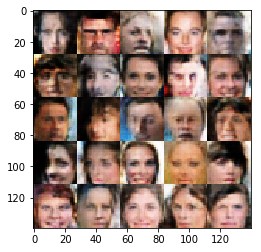

Epoch 1/1... Discriminator Loss: 2.6504... Generator Loss: 0.0846
Epoch 1/1... Discriminator Loss: 2.9196... Generator Loss: 0.0945
Epoch 1/1... Discriminator Loss: 1.5547... Generator Loss: 0.1876
Epoch 1/1... Discriminator Loss: 2.2680... Generator Loss: 0.1309
Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 0.4003
Epoch 1/1... Discriminator Loss: 2.1475... Generator Loss: 0.2562
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.1642
Epoch 1/1... Discriminator Loss: 0.6397... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: -0.0880... Generator Loss: 1.2765
Epoch 1/1... Discriminator Loss: 0.2021... Generator Loss: 2.3655


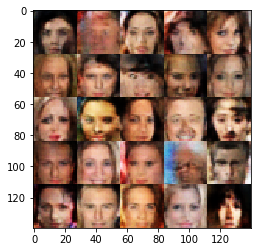

Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.3800
Epoch 1/1... Discriminator Loss: 0.4108... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: -0.2515... Generator Loss: 2.1418


In [21]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.